In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from typing import Tuple

# Device selection
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Target

Let $x = (x_0, x_1, x_2, x_3) \in [0,1]^4$. Define the rounding-to-bit map
$$
r(x) = \begin{cases}
1, & x \ge \tfrac{1}{2} \\
0, & x < \tfrac{1}{2}
\end{cases}
$$
Set $b_i = r(x_i) \in \{0,1\}$ for $i\in\{0,1,2,3\}$. Treat $(b_0,b_1)$ and $(b_2,b_3)$ as two 2-bit numbers and compute bitwise AND componentwise. The target function is
$$
f(x) = (\,b_0 \land b_2,\; b_1 \land b_3\,) \in \{0,1\}^2.
$$

In [7]:
def target_function_np(X: np.ndarray) -> np.ndarray:
    """
    X: (N, 4) with values in [0, 1]
    Returns Y: (N, 2) with values in {0.0, 1.0}
    Implements f(x) = (b0 AND b2, b1 AND b3) where bi = 1 if xi >= 0.5 else 0.
    """
    # Round to bits: >= 0.5 -> 1, else 0
    B = (X >= 0.5).astype(np.int32)

    # Componentwise AND: (b0 & b2, b1 & b3)
    y1 = B[:, 0] & B[:, 2]
    y2 = B[:, 1] & B[:, 3]

    Y = np.stack([y1, y2], axis=1).astype(np.float32)
    return Y


In [8]:
def make_datasets(
    n_train: int = 1024,
    n_test: int = 256,
    seed: int = 239,
):
    """
    Creates train/test tensors for the 4D->2D target_function_np mapping.
    Returns: X_train, Y_train, X_test, Y_test (float32 tensors)
    """
    rng = np.random.default_rng(seed)
    X_train_np = rng.uniform(0.0, 1.0, size=(n_train, 4)).astype(np.float32)
    X_test_np  = rng.uniform(0.0, 1.0, size=(n_test, 4)).astype(np.float32)

    Y_train_np = target_function_np(X_train_np)
    Y_test_np  = target_function_np(X_test_np)

    X_train = torch.from_numpy(X_train_np)
    Y_train = torch.from_numpy(Y_train_np)
    X_test  = torch.from_numpy(X_test_np)
    Y_test  = torch.from_numpy(Y_test_np)

    return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = make_datasets()


In [9]:
# Model: small MLP with Sigmoid head to keep outputs in [0,1]
class Net(nn.Module):
    def __init__(self, hidden=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)


@torch.no_grad()
def evaluate(model, X, Y):
    model.eval()
    preds = model(X)
    return torch.mean((preds - Y) ** 2).item()


def train_minimal(epochs=50, lr=1e-3, seed=0):
    torch.manual_seed(seed)

    Xtr, Ytr = X_train.to(device), Y_train.to(device)
    Xte, Yte = X_test.to(device), Y_test.to(device)

    model = Net().to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    history = {"epoch": [], "train_mse": [], "test_mse": []}

    for epoch in range(1, epochs + 1):
        model.train()
        pred = model(Xtr)
        loss = loss_fn(pred, Ytr)
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Evaluate every epoch and record for plotting
        train_mse = evaluate(model, Xtr, Ytr)
        test_mse = evaluate(model, Xte, Yte)
        history["epoch"].append(epoch)
        history["train_mse"].append(train_mse)
        history["test_mse"].append(test_mse)

    return model, history

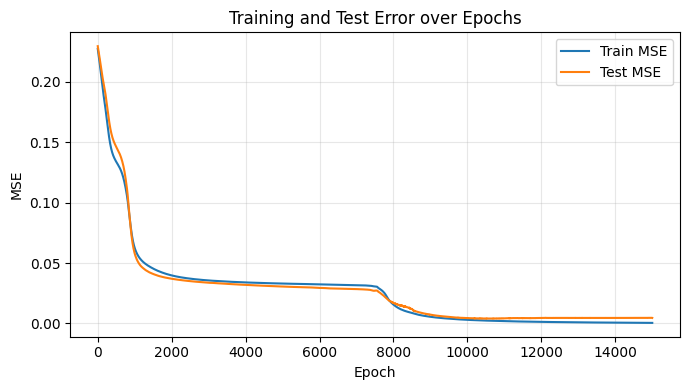

In [10]:
model, hist = train_minimal(epochs=15000)

# Visualize train/test MSE
plt.figure(figsize=(7, 4))
plt.plot(hist['epoch'], hist['train_mse'], label='Train MSE')
plt.plot(hist['epoch'], hist['test_mse'], label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Test Error over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def bitToFloat(b: int) -> float:
    return 0.01 if b == 0 else 0.99

for x in range(0, 1 << 2):
    for y in range(0, 1 << 2):
        z = (x & y)
        input = torch.tensor([[
            bitToFloat((x >> 1) & 1),
            bitToFloat(x & 1),
            bitToFloat((y >> 1) & 1),
            bitToFloat(y & 1)
        ]], dtype=torch.float32, device=device)
        output_tensor = torch.round(model(input)).to(torch.int64).cpu()
        output = np.array([int(output_tensor[0,0]>=0.5), int(output_tensor[0,1]>=0.5)])
        target = np.array([(z >> 1) & 1, z & 1], dtype=np.int32)

        print(f"{((x >> 1) & 1, x & 1, (y >> 1) & 1, y & 1)} -> a={output} e={target}")

(0, 0, 0, 0) -> a=[0, 0] e=[0 0]
(0, 0, 0, 1) -> a=[0, 0] e=[0 0]
(0, 0, 1, 0) -> a=[0, 0] e=[0 0]
(0, 0, 1, 1) -> a=[0, 0] e=[0 0]
(0, 1, 0, 0) -> a=[0, 0] e=[0 0]
(0, 1, 0, 1) -> a=[0, 1] e=[0 1]
(0, 1, 1, 0) -> a=[0, 0] e=[0 0]
(0, 1, 1, 1) -> a=[0, 1] e=[0 1]
(1, 0, 0, 0) -> a=[0, 0] e=[0 0]
(1, 0, 0, 1) -> a=[0, 0] e=[0 0]
(1, 0, 1, 0) -> a=[1, 0] e=[1 0]
(1, 0, 1, 1) -> a=[1, 0] e=[1 0]
(1, 1, 0, 0) -> a=[0, 0] e=[0 0]
(1, 1, 0, 1) -> a=[0, 1] e=[0 1]
(1, 1, 1, 0) -> a=[1, 0] e=[1 0]
(1, 1, 1, 1) -> a=[1, 1] e=[1 1]
